In [0]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


In [4]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
dataloader_args1 = dict(shuffle=True, batch_size=4, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
trainloader1 = torch.utils.data.DataLoader(trainset, **dataloader_args1)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)
testloader1 = torch.utils.data.DataLoader(testset, **dataloader_args1)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



plane   dog  deer  deer


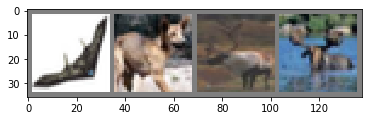

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader1)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch.nn as nn
import torch.nn.functional as F

class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=1, groups=nin)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
        ) # output_size = 32
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
        ) # output_size = 32
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
        ) # output_size = 32
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, dilation = 2,  bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        ) # output_size = 32
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=2, dilation=2,  bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        ) # output_size = 32
        self.convblock5_ = nn.Sequential(
            depthwise_separable_conv(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.convblock6 = nn.Sequential(
            depthwise_separable_conv(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
        ) # output_size = 32
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=2, dilation=2,  bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
        ) # output_size = 32
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1
        self.fc1 = nn.Linear(128, 10)
        #self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.convblock1(x) #3
        x = self.convblock2(x) #5
        x = self.convblock3(x) #9
        x = self.pool(x) #10
        x = self.convblock4(x) #18
        x = self.convblock5(x) #26
        x = self.convblock5_(x) #26
        x = self.pool1(x) #28
        x = self.convblock6(x) #52
        x = self.convblock7(x) #44
        x = self.pool2(x)
        x = self.gap(x)
        x = x.view(-1, 128)
        x = (self.fc1(x))
        #x = (self.fc2(x))
        return x

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [29]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = Net().to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
          Dropout-12           [-1, 32, 32, 32]               0
        MaxPool2d-13           [-1, 32, 16, 16]               0
           Conv2d-14           [-1

In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = StepLR(optimizer, step_size=15, gamma=0.75)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [31]:
import torch
from tqdm import tqdm
test_acc = []
train_acc = []
for epoch in range(50):  # loop over the dataset multiple times
    pbar = tqdm(trainloader)
    running_loss = 0.0
    scheduler.step()
    for i, (data, target) in enumerate(pbar):
        # get the inputs
        correct = 0
        processed = 0
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        # Predict
        y_pred = net(data)
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Epoch= {epoch} Loss={loss.item()} Batch_id={i} Accuracy={100*correct/processed:0.2f}')
        pbar.update(1)
    train_acc.append(100*correct/processed)
    correct = 0
    total = 0
    with torch.no_grad():
        pbar1 = tqdm(testloader)
        for i, (data, target) in enumerate(pbar1):
           data, target = data.to(device), target.to(device)
           outputs = net(data)
           _, predicted = torch.max(outputs.data, 1)
           total += target.size(0)
           correct += (predicted == target).sum().item()
          
        print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
        test_acc.append(100 * correct / total)  

print('Finished Training')

  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch= 0 Loss=1.4441051483154297 Batch_id=390 Accuracy=52.50: 100%|██████████| 391/391 [00:15<00:00, 24.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 54 %


Epoch= 1 Loss=0.9987266659736633 Batch_id=390 Accuracy=62.50: 100%|██████████| 391/391 [00:15<00:00, 24.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 67 %


Epoch= 2 Loss=0.5185403227806091 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [00:15<00:00, 25.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 71 %


Epoch= 3 Loss=0.9135273098945618 Batch_id=390 Accuracy=70.00: 100%|██████████| 391/391 [00:15<00:00, 28.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 74 %


Epoch= 4 Loss=0.7046316266059875 Batch_id=390 Accuracy=70.00: 100%|██████████| 391/391 [00:15<00:00, 25.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 73 %


Epoch= 5 Loss=0.5597983598709106 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 29.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 76 %


Epoch= 6 Loss=0.615249514579773 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:15<00:00, 25.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 77 %


Epoch= 7 Loss=0.8283681869506836 Batch_id=390 Accuracy=78.75: 100%|██████████| 391/391 [00:15<00:00, 25.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 78 %


Epoch= 8 Loss=0.5923793315887451 Batch_id=390 Accuracy=75.00: 100%|██████████| 391/391 [00:15<00:00, 25.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 79 %


Epoch= 9 Loss=0.5199544429779053 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:15<00:00, 25.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 79 %


Epoch= 10 Loss=0.45859336853027344 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 79 %


Epoch= 11 Loss=0.424407958984375 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 28.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 80 %


Epoch= 12 Loss=0.433726966381073 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 29.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 80 %


Epoch= 13 Loss=0.43625229597091675 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [00:15<00:00, 24.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 14 Loss=0.4640008807182312 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 29.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 15 Loss=0.4216957688331604 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 29.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 16 Loss=0.5293943285942078 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 25.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 17 Loss=0.331710547208786 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 25.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 18 Loss=0.5270512700080872 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 24.77it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 19 Loss=0.36570316553115845 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 20 Loss=0.4187895357608795 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 25.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 82 %


Epoch= 21 Loss=0.4678223729133606 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 24.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 22 Loss=0.48523807525634766 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 25.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 23 Loss=0.3929782211780548 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 25.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 81 %


Epoch= 24 Loss=0.30273357033729553 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 24.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 25 Loss=0.40949827432632446 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 29.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 26 Loss=0.3863268792629242 Batch_id=390 Accuracy=87.50: 100%|██████████| 391/391 [00:15<00:00, 28.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 27 Loss=0.33613523840904236 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 28 Loss=0.42635735869407654 Batch_id=390 Accuracy=83.75: 100%|██████████| 391/391 [00:15<00:00, 25.24it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 29 Loss=0.1842269003391266 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:15<00:00, 25.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 30 Loss=0.3020112216472626 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 25.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 31 Loss=0.392930805683136 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 29.05it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 32 Loss=0.4130858778953552 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 25.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 33 Loss=0.3168661594390869 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 28.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 34 Loss=0.3538438379764557 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 25.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 35 Loss=0.2658612132072449 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [00:15<00:00, 29.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 36 Loss=0.3130115568637848 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 28.85it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 37 Loss=0.345456063747406 Batch_id=390 Accuracy=90.00: 100%|██████████| 391/391 [00:15<00:00, 29.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 38 Loss=0.22243480384349823 Batch_id=390 Accuracy=96.25: 100%|██████████| 391/391 [00:15<00:00, 29.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 39 Loss=0.5776035189628601 Batch_id=390 Accuracy=85.00: 100%|██████████| 391/391 [00:15<00:00, 28.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 40 Loss=0.3858652114868164 Batch_id=390 Accuracy=88.75: 100%|██████████| 391/391 [00:15<00:00, 24.91it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 83 %


Epoch= 41 Loss=0.3237181007862091 Batch_id=390 Accuracy=86.25: 100%|██████████| 391/391 [00:15<00:00, 24.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 42 Loss=0.3553673326969147 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:16<00:00, 24.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 43 Loss=0.2554200291633606 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:15<00:00, 29.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85 %


Epoch= 44 Loss=0.23927488923072815 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:15<00:00, 28.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 84 %


Epoch= 45 Loss=0.174245223402977 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [00:15<00:00, 24.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85 %


Epoch= 46 Loss=0.24790294468402863 Batch_id=390 Accuracy=91.25: 100%|██████████| 391/391 [00:15<00:00, 28.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85 %


Epoch= 47 Loss=0.17687883973121643 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [00:15<00:00, 25.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85 %


Epoch= 48 Loss=0.39224478602409363 Batch_id=390 Accuracy=92.50: 100%|██████████| 391/391 [00:15<00:00, 28.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Accuracy of the network on the 10000 test images: 85 %


Epoch= 49 Loss=0.22487390041351318 Batch_id=390 Accuracy=95.00: 100%|██████████| 391/391 [00:15<00:00, 24.88it/s]
100%|██████████| 79/79 [00:02<00:00, 36.00it/s]

Accuracy of the network on the 10000 test images: 85 %
Finished Training


Text(0, 0.5, 'Accuracy')

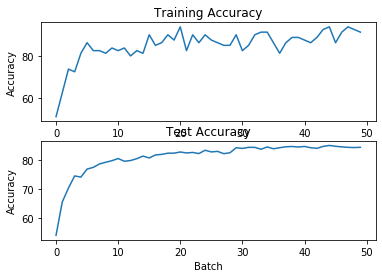

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(train_acc)
axs[0].set_title("Training Accuracy")
axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Accuracy")
axs[1].plot(test_acc)
axs[1].set_title("Test Accuracy")
axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Accuracy")

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:   bird horse horse  ship


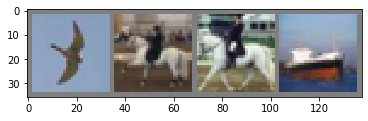

In [17]:
dataiter = iter(testloader1)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images.cuda())

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [26]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  plane horse horse  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for i, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == target).squeeze()
        for i in range(4):
            label = target[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 86 %
Accuracy of   car : 85 %
Accuracy of  bird : 82 %
Accuracy of   cat : 83 %
Accuracy of  deer : 90 %
Accuracy of   dog : 83 %
Accuracy of  frog : 93 %
Accuracy of horse : 96 %
Accuracy of  ship : 97 %
Accuracy of truck : 97 %
